In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [3]:
#Reading our SQLite3 Database
conn = sqlite3.connect('LOL_Match_Champion_Database.sqlite3')
cur = conn.cursor()

df_match_summary = pd.read_sql('''SELECT match_summary.summonerName,match_summary.teamId, match_summary.kills, match_summary.kills, match_summary.assists, match_summary.deaths,match_summary.goldEarned,
match_summary.neutralMinionsKilled,match_summary.totalMinionsKilled,match_summary.win,champion_table.champion, teamPosition_table.teamPosition, matchid_table.match
FROM match_summary JOIN champion_table
ON match_summary.champion_id = champion_table.champion_id 
JOIN teamPosition_table
ON match_summary.teamPosition_id = teamPosition_table.teamPosition_id
JOIN matchid_table
ON match_summary.match_id = matchid_table.match_id''', conn)

df_match_summary.shape

(10020, 13)

In [4]:
#Reorganizing the data: We want to condense each match into a row. Each row has one team and if they won.
#Gather values from winning games
df_summary_win = df_match_summary.loc[df_match_summary['win']==1]
#Unique matches to dataframe
matchlist = []
#List comprehension
matchlist=[i for i in df_match_summary['match']]
#Set to get unique match ids. This is our dictionary keys
uniquematchlist = list({x for x in matchlist})

In [5]:
#A list of champions from each match key will be our dic values.
windict = {}
for key in uniquematchlist:
    windict[key] = None
for i in uniquematchlist:
    a = df_summary_win[df_summary_win['match'] == i]
    championlist = [champ for champ in a['champion']]
    windict[i] = championlist
df_win_comp = pd.DataFrame.from_dict(windict, orient = 'index')
df_win_comp['win'] = 1

In [6]:
#Do same thing but for losing games
df_summary_loss = df_match_summary.loc[df_match_summary['win']==0]
#A list of champions from each match key will be our dic values.
lossdict = {}
for key in uniquematchlist:
    lossdict[key] = None
for i in uniquematchlist:
    a = df_summary_loss[df_summary_loss['match'] == i]
    championlist = [champ for champ in a['champion']]
    lossdict[i] = championlist
df_loss_comp = pd.DataFrame.from_dict(lossdict, orient = 'index')
df_loss_comp['win'] = 0

In [7]:
#Join the dataframes together. The list we generated the champions from is ordered so we know each champ belongs in the right spot
df_team_comp = pd.concat([df_win_comp, df_loss_comp])
df_team_comp= df_team_comp.rename(columns={0:'Top',1:'Jungle',2:'Mid',3:'ADC',4:'Support'})
df_team_comp.reset_index(inplace=True)
df_team_comp = df_team_comp.rename(columns= {'index':'MatchID'})
df_team_comp.sort_values(by='MatchID')

,MatchID,Top,Jungle,Mid,ADC,Support,win
784,NA1_4191686936,Akshan,JarvanIV,Vladimir,Jinx,Lulu,1
1786,NA1_4191686936,Graves,Viego,Sylas,Zeri,Nami,0
1584,NA1_4191752706,Darius,FiddleSticks,Qiyana,Jinx,Thresh,0
582,NA1_4191752706,Gwen,Nautilus,Ryze,Jhin,LeeSin,1
336,NA1_4191851012,Darius,JarvanIV,Sylas,Jinx,Soraka,1
...,...,...,...,...,...,...,...
132,NA1_4262790270,Malphite,Khazix,AurelionSol,Jinx,Blitzcrank,1
1857,NA1_4262799959,Volibear,Trundle,Viktor,Jhin,Morgana,0
855,NA1_4262799959,DrMundo,LeeSin,Corki,Lucian,Xerath,1
794,NA1_4262821937,Poppy,Kayn,Ryze,Draven,Nautilus,1


In [8]:
#Check for missing values
df_team_comp.isna().any()

MatchID    False
Top        False
Jungle     False
Mid        False
ADC        False
Support    False
win        False
dtype: bool

Unique Entries: 115


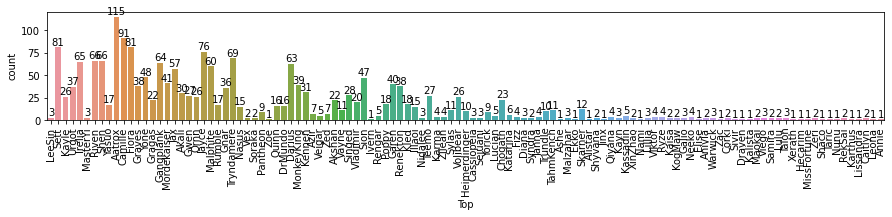

In [77]:
#Explore the Data
print('Unique Entries:',df_team_comp['Top'].nunique())
plt.figure(figsize=(15,2))
ax = sns.countplot(x='Top', data=df_team_comp)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

Unique Entries: 86


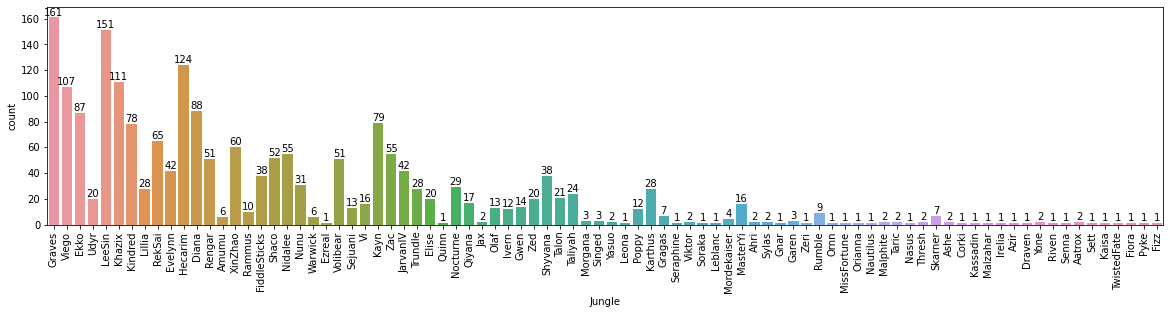

In [76]:
print('Unique Entries:',df_team_comp['Jungle'].nunique())
plt.figure(figsize=(20,4))
ax = sns.countplot(x='Jungle', data=df_team_comp)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

Unique Entries: 127


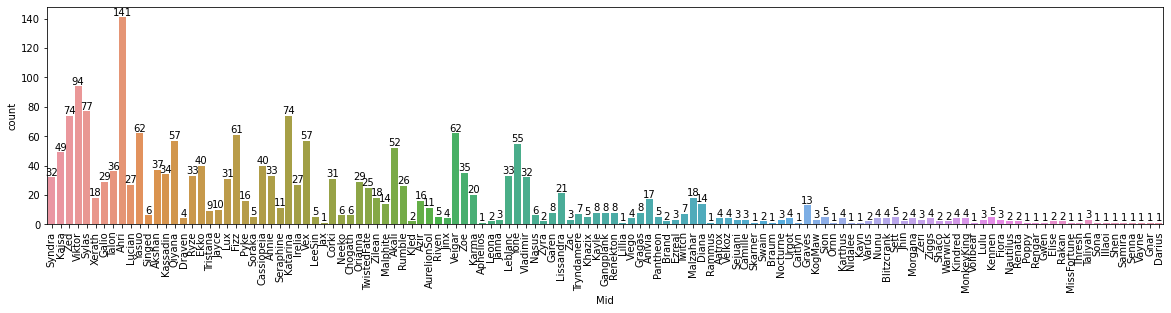

In [73]:
print('Unique Entries:',df_team_comp['Mid'].nunique())
plt.figure(figsize=(20,4))
ax = sns.countplot(x='Mid', data=df_team_comp)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

Unique Entries: 81


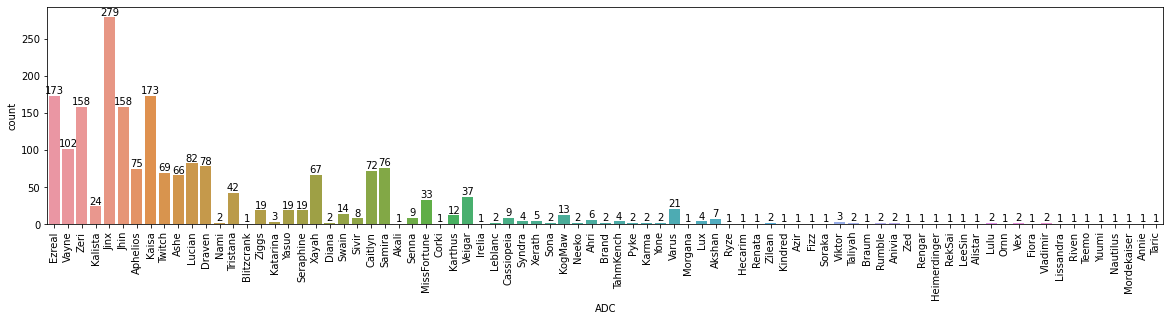

In [74]:
print('Unique Entries:',df_team_comp['ADC'].nunique())
plt.figure(figsize=(20,4))
ax = sns.countplot(x='ADC', data=df_team_comp)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

Unique Entries: 94


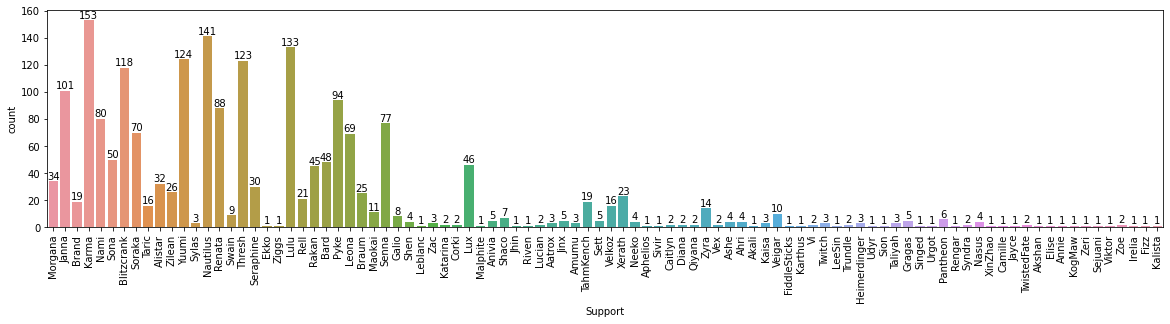

In [75]:
print('Unique Entries:',df_team_comp['Support'].nunique())
plt.figure(figsize=(20,4))
ax = sns.countplot(x='Support', data=df_team_comp)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

In [14]:
#Now to apply Machine Learning Processes
team_features = ['Top','Jungle','Mid','ADC','Support']
X=df_team_comp[team_features]
Y=df_team_comp.win
train_X,val_X,train_Y,val_Y = train_test_split(X,Y,random_state=0, train_size=0.8, test_size=0.2)

In [15]:
#Convienent variable for all categorical columns
s = (train_X.dtypes == 'object')
object_cols = list(s[s].index)
object_cols

['Top', 'Jungle', 'Mid', 'ADC', 'Support']

In [18]:
#We have so many possibilities that exist for team composition with 158 champions. 
#And we have not even explored the enemy team comp affecting results either. Counter picks exist. 
#To account for that we would need to make a new predictor variable based on using one team 
#"Does blue team win based in this match comp?"

In [19]:
#Our original model has a glaring problem. Its constructed to predict whether a team comp will win. 
#However, it fails to accommodate a League fundamental: Counterpicking.
#As champions are picked on one team, the other team may change their pick with a champ that counters another.
#To solve this, we will need to change the dataframe once more. Each row will need to have both teams.
#Our win variable will measure if team 1 will win based on their comp + opponent comp. 
    
bluewin = df_match_summary.loc[(df_match_summary['win'] == 1) & (df_match_summary['teamId'] == 100)]
bluelost = df_match_summary.loc[(df_match_summary['win'] == 0) & (df_match_summary['teamId'] == 100)]
matches = df_match_summary['match']
matchlist = list({x for x in matches})

#Match Ids where blue won
bluewinlist = list({x for x in bluewin['match']})

#Match Ids where blue lost
bluelostlist = list({x for x in bluelost['match']})

#Make values into keys
bluewindict = {}
for key in bluewinlist:
    bluewindict[key] = None


bluelossdict = {}
for key in bluelostlist:
    bluelossdict[key] = None
    
matchdict = {}
for key in matchlist:
    matchdict[key] = None


#Make values the list of champions    
    
for match in matchdict.keys():
    a = df_match_summary[df_match_summary['match'] == match]
    championlist = [champ for champ in a['champion']]
    for i in bluewinlist:
        if match == i:
            championlist.append(1)
    for x in bluelostlist:
        if match == x:
            championlist.append(0)
    matchdict[match] = championlist
df_match_comp = pd.DataFrame.from_dict(matchdict, orient='index')

In [20]:
df_match_comp= df_match_comp.rename(columns={0:'BlueTop',1:'BlueJungle',2:'BlueMid',3:'BlueADC',4:'BlueSupport',
                                            5:'RedTop',6:'RedJungle',7:'RedMid',8:'RedADC',9:'RedSupport',10:'win'})
df_match_comp.reset_index(inplace=True)
df_match_comp = df_match_comp.rename(columns= {'index':'MatchID'})
df_match_comp.head()

,MatchID,BlueTop,BlueJungle,BlueMid,BlueADC,BlueSupport,RedTop,RedJungle,RedMid,RedADC,RedSupport,win
0,NA1_4256483177,LeeSin,Graves,Syndra,Ezreal,Morgana,Jayce,Hecarim,Xerath,Ashe,Yuumi,1
1,NA1_4245150525,Sett,Viego,Kaisa,Vayne,Janna,Aatrox,Morgana,Viktor,Jinx,Zilean,1
2,NA1_4262470347,Kayle,Graves,Zed,Zeri,Brand,Vayne,Ekko,Akali,Kaisa,Nautilus,1
3,NA1_4213682939,Urgot,Ekko,Viktor,Zeri,Karma,MonkeyKing,Kindred,Kennen,Jhin,Senna,1
4,NA1_4236856134,Sett,Graves,Sylas,Kalista,Nami,Fiora,Hecarim,Fizz,Caitlyn,Janna,1


In [78]:
#First we should clean the data more by reducing the amount of categories that exist.
#Exploration shows many champions picked only once or twice for a role. We will label these champs "Uncommon"
#We have such a high cardinality with our model due to the sheer number of champions that makes it hard for our model to identify patterns.
poslist= ['Top','Jungle','Mid','ADC','Support'] 
uncommposdict = {}
for key in poslist:
    uncommposdict[key] = None
def uncommoncount(position):
    count = df_team_comp[position].value_counts()
    countdict = count.to_dict()
    uncommposlist = [key for key, value in countdict.items() if value <=15]
    uncommposdict[position] = uncommposlist

for i in poslist:
    uncommoncount(i)

In [79]:
#Apply the uncommon champions per position dictionary to this new dataframe
extenduncomdict = {}
keys = ['BlueTop', 'BlueJungle', 'BlueMid', 'BlueADC', 'BlueSupport',
       'RedTop', 'RedJungle', 'RedMid', 'RedADC', 'RedSupport']
for key in keys:
    extenduncomdict[key] = None

extenduncomdict['BlueTop'] = uncommposdict['Top']
extenduncomdict['RedTop'] = uncommposdict['Top']

extenduncomdict['BlueJungle'] = uncommposdict['Jungle']
extenduncomdict['RedJungle'] = uncommposdict['Jungle']

extenduncomdict['BlueMid'] = uncommposdict['Mid']
extenduncomdict['RedMid'] = uncommposdict['Mid']

extenduncomdict['BlueADC'] = uncommposdict['ADC']
extenduncomdict['RedADC'] = uncommposdict['ADC']

extenduncomdict['BlueSupport'] = uncommposdict['Support']
extenduncomdict['RedSupport'] = uncommposdict['Support']

In [80]:
#Make the new dataframe with "Uncommon Champions"
df_match_redux = df_match_comp.copy()
for key in extenduncomdict.keys():
    for value in extenduncomdict[key]:
        df_match_redux[key] = df_match_redux[key].replace(value,'Uncommon')

In [81]:
teamposlist= ['BlueTop', 'BlueJungle', 'BlueMid', 'BlueADC', 'BlueSupport',
       'RedTop', 'RedJungle', 'RedMid', 'RedADC', 'RedSupport'] 
for i in teamposlist:
    print('Original',i, df_match_comp[i].nunique())
    print('Reduced',i,df_match_redux[i].nunique())

Original BlueTop 101
Reduced BlueTop 41
Original BlueJungle 72
Reduced BlueJungle 34
Original BlueMid 110
Reduced BlueMid 41
Original BlueADC 68
Reduced BlueADC 23
Original BlueSupport 76
Reduced BlueSupport 29
Original RedTop 96
Reduced RedTop 41
Original RedJungle 68
Reduced RedJungle 34
Original RedMid 106
Reduced RedMid 41
Original RedADC 59
Reduced RedADC 23
Original RedSupport 71
Reduced RedSupport 29


In [82]:
def confusionprintout(train_X,train_Y,valid_X,val_Y):
    preds = model.predict(train_X)
    cm = confusion_matrix(train_Y, preds)
    TN, FP, FN, TP = cm.ravel()

    print('True Positive(TP)  = ', TP)
    print('False Positive(FP) = ', FP)
    print('True Negative(TN)  = ', TN)
    print('False Negative(FN) = ', FN)

    accuracy =  (TP+TN) /(TP+FP+TN+FN)

    print('Accuracy of the binary classification Training = {:0.3f}'.format(accuracy))
    
    preds = model.predict(valid_X)
    cm = confusion_matrix(val_Y, preds)
    TN, FP, FN, TP = cm.ravel()

    print('True Positive(TP)  = ', TP)
    print('False Positive(FP) = ', FP)
    print('True Negative(TN)  = ', TN)
    print('False Negative(FN) = ', FN)

    accuracy =  (TP+TN) /(TP+FP+TN+FN)

    print('Accuracy of the binary classification Validation = {:0.3f}'.format(accuracy))

In [83]:
#Do Onehot Encoding on our new data
team_features = ['BlueTop', 'BlueJungle', 'BlueMid', 'BlueADC', 'BlueSupport',
       'RedTop', 'RedJungle', 'RedMid', 'RedADC', 'RedSupport']
X=df_match_redux[team_features]
Y=df_match_redux.win
train_X,val_X,train_Y,val_Y = train_test_split(X,Y,random_state=0, train_size=0.8, test_size=0.2)

#Apply Onehot Encoding to each column with categorical data...so all of them
OH_encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X))

#One hot encoding removes index. Put it back. This completes our dataset.
OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index

In [88]:
#Do K-Fold Cross Validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [84]:
#We try using a Random Forest Classifier to model this as well
model = RandomForestClassifier(random_state=1, n_estimators=1000, criterion='entropy',max_depth=3)
model.fit(OH_cols_train, train_Y)

confusionprintout(OH_cols_train,train_Y,OH_cols_valid,val_Y)

True Positive(TP)  =  259
False Positive(FP) =  39
True Negative(TN)  =  365
False Negative(FN) =  138
Accuracy of the binary classification Training = 0.779
True Positive(TP)  =  38
False Positive(FP) =  36
True Negative(TN)  =  60
False Negative(FN) =  67
Accuracy of the binary classification Validation = 0.488


In [85]:
import xgboost as xgb
#xgb uses gradient boosting, forms an ensemble of weak prediction models (like decision trees)


#learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
#max_depth: determines how deeply each tree is allowed to grow during any boosting round.
#subsample: percentage of samples used per tree. Low value can lead to underfitting.
#colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
#n_estimators: number of trees you want to build.
#objective: determines the loss function to be used like reg:linear for regression problems
#reg:logistic for classification problems with only decision
#binary:logistic for classification problems with probability.


model = xgb.XGBClassifier(objective = 'reg:logistic', colsample_bytree= 0.3,learning_rate = 0.1,n_estimators=100, max_depth=3)
model.fit(OH_cols_train,train_Y)

confusionprintout(OH_cols_train,train_Y,OH_cols_valid,val_Y)

True Positive(TP)  =  277
False Positive(FP) =  84
True Negative(TN)  =  320
False Negative(FN) =  120
Accuracy of the binary classification Training = 0.745
True Positive(TP)  =  50
False Positive(FP) =  41
True Negative(TN)  =  55
False Negative(FN) =  55
Accuracy of the binary classification Validation = 0.522


C:\Users\cruzc\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [96]:
#Onehot encoding but for not split sets
X=df_match_redux[team_features]
Y=df_match_redux.win
#Apply Onehot Encoding to each column with categorical data...so all of them
OH_encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
OH_X = pd.DataFrame(OH_encoder.fit_transform(X))


#One hot encoding removes index. Put it back. This completes our dataset.
OH_X.index = X.index

In [99]:
#NOt accurate: Should have done cross val on ENTIRE X and Y not the already separated train and test. 
model = RandomForestClassifier(random_state=1, n_estimators=2000, criterion='entropy',max_depth=3)
scores = cross_val_score(model, OH_X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
print(scores)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

[0.48514851 0.54455446 0.48       0.55       0.43       0.55
 0.54       0.55       0.53       0.52      ]
Accuracy: 0.518 (0.038)


In [98]:
model = xgb.XGBClassifier(objective = 'reg:logistic', colsample_bytree= 0.3,learning_rate = 0.1,n_estimators=100, max_depth=3)
scores = cross_val_score(model, OH_X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
print(scores)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

[0.58415842 0.53465347 0.57       0.57       0.5        0.62
 0.54       0.63       0.55       0.45      ]
Accuracy: 0.555 (0.051)
